Se quiere resolver el problema de un Oscilador Armónico Amortiguado:

$$m\frac{d^2x}{dt^2} + \mu\frac{dx}{dt} + kx =0,$$

con las condiciones iniciales

$$x(0) = 1 \hspace{1cm},\hspace{1cm}\frac{dx}{dt}=0.$$

Se tomara en cuenta el problema del oscilador subamortiguado:

$$\delta<\omega_0,\hspace{1cm}con \hspace{1cm} \delta=\frac{\mu}{2m},\hspace{1cm}\omega_0 =\sqrt{\frac{k}{m}}$$

que tiene la siguiente solución exacta:

$$x(t) = e^{\delta t}(2Acos(\phi +\omega t)),\hspace{1cm} con\hspace{1cm} \omega=\sqrt{\omega^2_0 - \delta^2}.$$

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio

In [2]:
def oscillator(d, w0, x):
    assert d < w0
    w = tf.sqrt(tf.cast(w0**2 - d**2, tf.float32))
    phi = tf.atan(-d / w)
    A = 1 / (2 * tf.cos(phi))
    cos = tf.cos(phi + w * x)
    sin = tf.sin(phi + w * x)
    exp = tf.exp(-d * x)
    y = exp * 2 * A * cos
    return y

class FCN(tf.keras.Model):
    def __init__(self, N_HIDDEN, N_LAYERS):
        super(FCN, self).__init__()
        self.activation = tf.keras.layers.Activation('tanh')
        self.fcs = tf.keras.layers.Dense(N_HIDDEN, activation=self.activation)
        self.fch = [tf.keras.layers.Dense(N_HIDDEN, activation=self.activation) for _ in range(N_LAYERS - 1)]
        self.fce = tf.keras.layers.Dense(1)
        
    def call(self, x):
        x = self.fcs(x)
        for layer in self.fch:
            x = layer(x)
        x = self.fce(x)
        return x

Se generan los datos de entrenamiento a partir de una pequeña parte de la solución analítica exacta.

Se toma $\delta = 2$ y $\omega_0 = 20$ y se intenta aprender la solución en el dominio $x\in[0,1].$

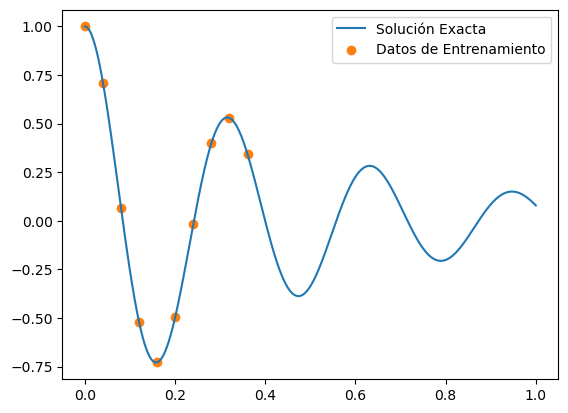

In [3]:
d, w0 = 2, 20

x = np.linspace(0, 1, 500).reshape(-1, 1).astype(np.float32)
y = oscillator(d, w0, x)

x_data = x[0:200:20]
y_data = y[0:200:20]

plt.figure()
plt.plot(x, y, label="Solución Exacta")
plt.scatter(x_data, y_data, color="tab:orange", label="Datos de Entrenamiento")
plt.legend()
plt.show()

Ahora, se entrena una red neuronal para que se ajuste a estos puntos de entrenamiento. Esta es capaz de ajustarse a una solución muy cercana a los puntos de entrenamiento, pero no aprende correctamente mas alla de ellos.

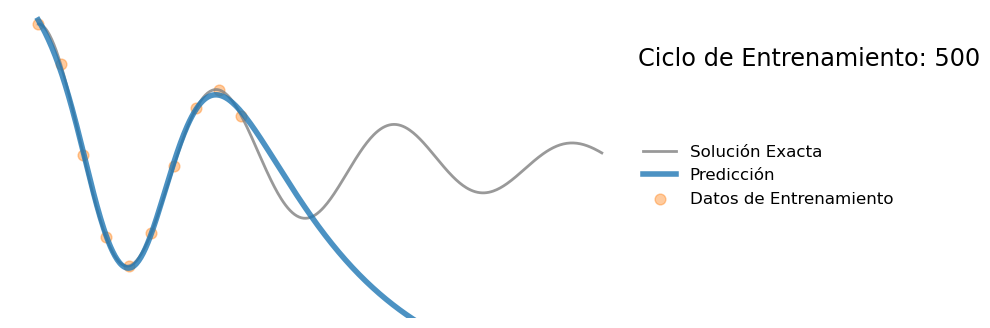

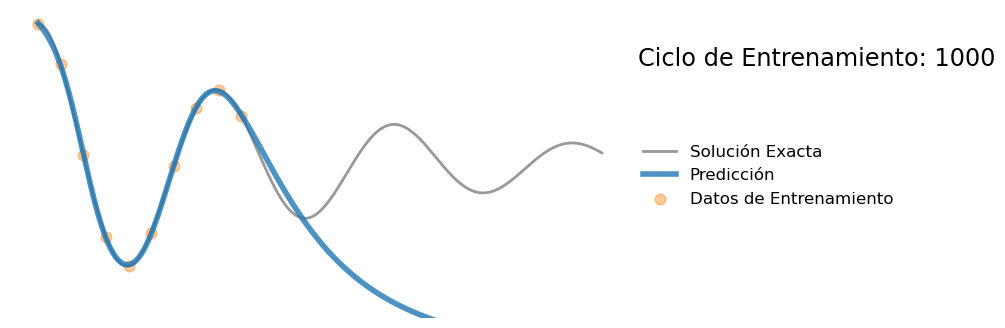

In [5]:
def plot_result(x, y, x_data, y_data, yh, xp=None):
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Solución Exacta")
    plt.plot(x, yh, color="tab:blue", linewidth=4, alpha=0.8, label="Predicción")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Datos de Entrenamiento')
    if xp is not None:
        plt.scatter(xp, -0*tf.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Puntos de Colocación') 
    plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Ciclo de Entrenamiento: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")
    
tf.random.set_seed(123)
model = FCN(32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

files = [] 
for i in range(1000):
    with tf.GradientTape() as tape:
        yh = model(x_data)
        loss = tf.reduce_mean(tf.square(yh - y_data))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if (i+1) % 10 == 0:
        yh = model(x) 
        plot_result(x,y,x_data,y_data,yh)
        file = "plots/nn_%.8i.png" % (i + 1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i + 1) % 500 == 0:
            plt.show()
        else:
            plt.close("all")

images = []
for filename in files:
    images.append(imageio.v2.imread(filename))
imageio.mimsave('nn.gif', images, fps=20)

Finalmente, se agrega la red informada por la fisica, añadiendo la ecuacion diferencial a la funcion de costo.

Esto garantizará que la solución sea coherente con la ecuación diferencial, penalizando el residual de la ecuacion sobre los puntos de colocación. En este caso se toman 30 puntos sobre el dominio.

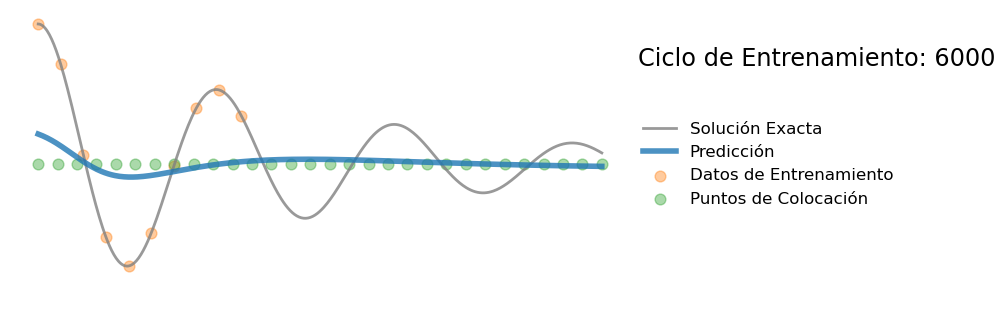

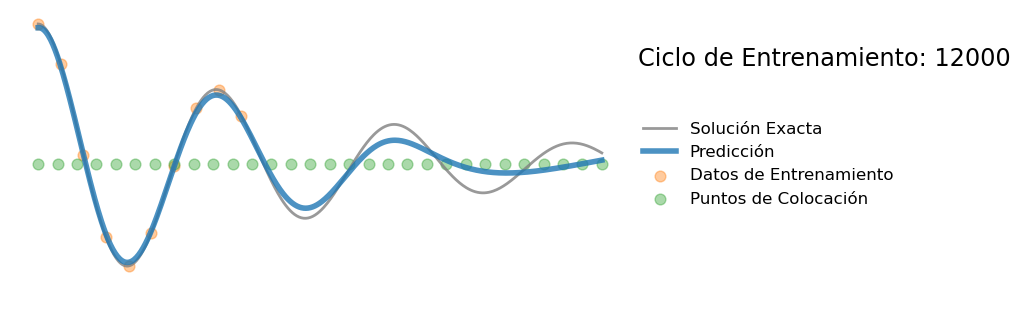

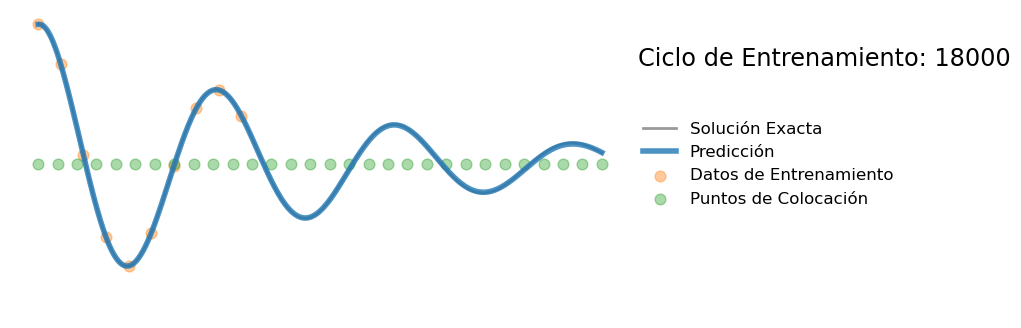

In [6]:
x_physics = tf.Variable(tf.linspace(0.0, 1.0, 30)[:, tf.newaxis])
mu, k = 2 * d, w0**2

tf.random.set_seed(123)
model = FCN(32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
files = []
for i in range(20000):
    with tf.GradientTape(persistent=True) as tape:
        yh = model(x_data)
        loss1 = tf.reduce_mean(tf.square(yh - y_data))

        yhp = model(x_physics)
        dx = tape.gradient(yhp, x_physics)
        dx2 = tape.gradient(dx, x_physics)
        physics = dx2 + mu * dx + k * yhp 
        loss2 = (1e-4) * tf.reduce_mean(tf.square(physics))

        loss = loss1 + loss2

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if (i + 1) % 150 == 0:
        yh = model(x)
        xp = x_physics
        plot_result(x, y, x_data, y_data, yh, xp)
        file = f"plots/pinn_{i+1:08d}.png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i + 1) % 6000 == 0:
            plt.show()
        else:
            plt.close("all")

images = []
for filename in files:
    images.append(imageio.v2.imread(filename))
imageio.mimsave('pinn.gif', images, fps=20)

[Fuente](https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb)